In [1]:
#importing all the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,accuracy_score,roc_curve,confusion_matrix

In [2]:
%pip install instaloader


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import instaloader
import json

def fetch_account_info(username):
    loader = instaloader.Instaloader()

    try:
        profile = instaloader.Profile.from_username(loader.context, username)
        metadata = profile._metadata()

        account_info = {
            "username": metadata['username'],
            "followers": metadata['edge_followed_by']['count'],
            "following": metadata['edge_follow']['count'],
            "posts": metadata['edge_owner_to_timeline_media']['count'],
            "profile_picture": metadata['profile_pic_url'],
            "is_private": metadata['is_private'],
            "is_verified": metadata['is_verified'],
            "external URLS": metadata["external_url"],
            "full_name": len(metadata["full_name"].split()),
            "business_category_name":metadata["business_category_name"],
            "biography":len(metadata["biography"].split()),
            "id":metadata["id"]

        }

        return account_info

    except instaloader.exceptions.ProfileNotExistsException:
        print(f"Profile {username} does not exist.")
        return None
    except instaloader.exceptions.InstaloaderException as e:
        print(f"An error occurred: {e}")
        return None

usernames = input("Enter Instagram usernames separated by commas: ").split(',')
usernames = [username.strip() for username in usernames]  # Strip any extra whitespace

# Fetch and display account information
results = {}

for username in usernames:
    account_info = fetch_account_info(username)
    if account_info:
        results = account_info
    else:
        results = "Could not fetch account information."


print(json.dumps(results,indent=4))


{
    "username": "latenight_engineer",
    "followers": 306,
    "following": 365,
    "posts": 16,
    "profile_picture": "https://instagram.fdel3-1.fna.fbcdn.net/v/t51.2885-19/387268867_228176180273391_6095926253579062698_n.jpg?stp=dst-jpg_e0_s150x150&_nc_ht=instagram.fdel3-1.fna.fbcdn.net&_nc_cat=103&_nc_ohc=D3ozLoLQxmEQ7kNvgG-gV7g&edm=AOQ1c0wBAAAA&ccb=7-5&oh=00_AYB2r3EGjdkWJLgRnlARV4GQ5qF6r7yx9rQxN68QA3P43Q&oe=66620E0A&_nc_sid=8b3546",
    "is_private": false,
    "is_verified": false,
    "external URLS": "https://shloksharma273.wixsite.com/mysite",
    "full_name": 2,
    "business_category_name": null,
    "biography": 7
}


In [4]:
if results["is_private"]=="null":
    results["is_private"]=0
else:
    results["is_private"]=1

In [5]:
if results["is_verified"]=="null":
    results["is_verified"]=0
else:
    results["is_verified"]=1

In [6]:
if results["external URLS"] is None:
    results["external URLS"]=0
else:
    results["external URLS"]=1

In [7]:
instagram_df_test = pd.read_csv('test.csv')
instagram_df_train = pd.read_csv('train.csv')

In [8]:
instagram_df_test.head()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.33,1,0.33,1,30,0,1,35,488,604,0
1,1,0.00,5,0.00,0,64,0,1,3,35,6,0
2,1,0.00,2,0.00,0,82,0,1,319,328,668,0
3,1,0.00,1,0.00,0,143,0,1,273,14890,7369,0
4,1,0.50,1,0.00,0,76,0,1,6,225,356,0


In [9]:
x_train = instagram_df_train.drop(columns = ['fake'])
x_test = instagram_df_test.drop(columns = ['fake'])
x_train

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows
0,1,0.27,0,0.00,0,53,0,0,32,1000,955
1,1,0.00,2,0.00,0,44,0,0,286,2740,533
2,1,0.10,2,0.00,0,0,0,1,13,159,98
3,1,0.00,1,0.00,0,82,0,0,679,414,651
4,1,0.00,2,0.00,0,0,0,1,6,151,126
...,...,...,...,...,...,...,...,...,...,...,...
571,1,0.55,1,0.44,0,0,0,0,33,166,596
572,1,0.38,1,0.33,0,21,0,0,44,66,75
573,1,0.57,2,0.00,0,0,0,0,4,96,339
574,1,0.57,1,0.00,0,11,0,0,0,57,73


In [10]:
y_train = instagram_df_train['fake']
y_test = instagram_df_test['fake']
y_train

0      0
1      0
2      0
3      0
4      0
      ..
571    1
572    1
573    1
574    1
575    1
Name: fake, Length: 576, dtype: int64

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(x_train)
X_test = scaler_x.transform(x_test)

In [12]:
Y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
Y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

In [13]:
X_train.shape,X_test.shape

((576, 11), (120, 11))

In [14]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

#Building the main model***

model = Sequential() 
model.add(Dense(50,input_dim = 11, activation = "relu")) #Initial Layer
model.add(Dropout(0.3))
model.add(Dense(150, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(25, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(2, activation = "softmax")) #output layer

model.summary()

c:\Users\gauri\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 150)            │         7,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         3,775 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,077 (47.18 KB)

 Trainable params: 12,077 (47.18 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [16]:
epochs_hist = model.fit(X_train, Y_train, epochs = 20, verbose = 1, validation_split = 0.1)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5174 - loss: 0.7186 - val_accuracy: 0.8103 - val_loss: 0.4227
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8245 - loss: 0.4999 - val_accuracy: 0.8621 - val_loss: 0.2669
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8481 - loss: 0.4300 - val_accuracy: 0.8448 - val_loss: 0.2659
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9135 - loss: 0.2864 - val_accuracy: 0.8276 - val_loss: 0.2658
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8862 - loss: 0.2928 - val_accuracy: 0.8448 - val_loss: 0.2529
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9027 - loss: 0.2676 - val_accuracy: 0.8448 - val_loss: 0.2956
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8899 - loss: 0.3145 - val_accuracy: 0.8448 - val_loss: 0.2405
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9291 - loss: 0.2286 - val_accuracy: 0.8621 - val_loss

In [17]:
print(epochs_hist.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


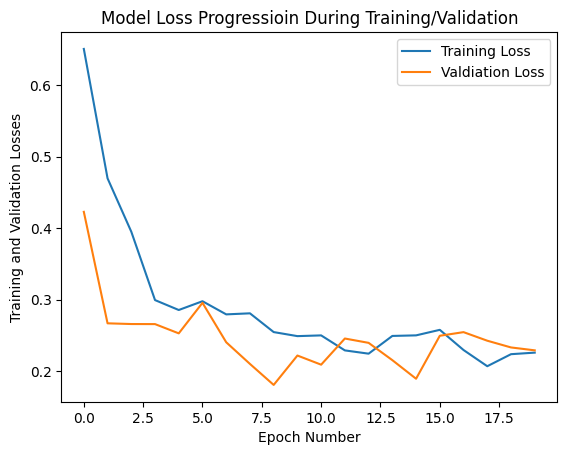

In [18]:
plt.plot(epochs_hist.history['loss'])
plt.plot(epochs_hist.history['val_loss'])

plt.title('Model Loss Progressioin During Training/Validation')
plt.xlabel('Epoch Number')
plt.ylabel('Training and Validation Losses')
plt.legend(['Training Loss','Valdiation Loss'])


In [19]:
predicted = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [20]:
predicted_value = []
test = []
for i in predicted:
    predicted_value.append(np.argmax(i))

for i in Y_test:
    test.append(np.argmax(i))

In [21]:
new_input = np.array([[1,0.33,2,0.33,0,0,0,1,2,162,400]])

In [22]:
predicted_probabilities = model.predict(new_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [23]:
predicted_class = np.argmax(predicted_probabilities, axis=1)

In [24]:
print("Predicted class:", predicted_class[0])

Predicted class: 0
